In [158]:
#imports
import pickle
import os
import tensorflow.keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import gc
import opendatasets as od
import nltk
import warnings
import tensorflow as tf
import re,string,unicodedata
from keras import models    
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/garrisonwinter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/garrisonwinter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garrisonwinter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Let's Get Our Data

* Our data is Trending youtube videos in US, CA and GB
* For this kernal title, category and view_count will be used for each video


od.download('https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset', force=True)

In [159]:
#Let's read our data 

columns = ['title','categoryId','view_count','video_id']

main_data = pd.read_csv("/Users/garrisonwinter/Desktop/Comp_Sci/Data Science Course/CSE6242/youtube-trending-video-dataset/US_youtube_trending_data.csv",usecols=columns)
# old_main_data = pd.read_csv("/kaggle/input/youtube-new/USvideos.csv",usecols=['title', 'category_id',"views"])
# old_main_data = old_main_data.rename({'category_id': 'categoryId', 'views': 'view_count'}, axis=1)
ca_main_data = pd.read_csv("/Users/garrisonwinter/Desktop/Comp_Sci/Data Science Course/CSE6242/youtube-trending-video-dataset/CA_youtube_trending_data.csv",usecols=columns)
gb_main_data = pd.read_csv("/Users/garrisonwinter/Desktop/Comp_Sci/Data Science Course/CSE6242/youtube-trending-video-dataset/GB_youtube_trending_data.csv",usecols=columns)
main_data = pd.concat([main_data,ca_main_data,gb_main_data],axis=0,ignore_index=True)

del gb_main_data
del ca_main_data
gc.collect()
main_data.head()

,video_id,title,categoryId,view_count
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,22,1514614
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,20,2381688
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,24,2038853
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,10,496771
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,26,1123889


# Data Analysis

**In total we have 503.475 video which all have non-null title and category data**

In [160]:
with open("/Users/garrisonwinter/Desktop/Comp_Sci/Data Science Course/CSE6242/youtube-trending-video-dataset/US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
main_data['category_name'] = main_data['categoryId'].map(cat_dict)

**Total we have 44 different type of categoriesi but we have in our data there are videos which belongs only one of the 12 different category**

**The distrubituon of categories in our data**
* **We can see that Gaming, Entertainment and music categories are outnumbered**
* **but since the database is big enough to not to let these categories to dominant the other ones.**


# Data Cleaning
* Cleaning the data is one of the most important part of nlp, because no matter how efficient your model is, if you are working with uncleaned data, you should not expect very high efficiency.  

* Removing unnecessary spaces.
* Cleaning the numbers
* Correction of the misspelled words
* Correction of rare words
* Cleaning bad case words
* Cleaning the repeat words
* Cleaning the emojies, unneccessary punctiations, characters
* Cleaning the StopWords

In [161]:
print(main_data.shape)
main_data = main_data.drop_duplicates(['video_id'], keep='first')
test = main_data.copy()
print(main_data.shape)

(578326, 5)
(61384, 5)


In [162]:
bad_case_words = {'nationalpost':'national post','businessinsider':'business insider','jewprofits': 'jew profits', 'QMAS': 'Quality Migrant Admission Scheme', 'casterating': 'castrating',
                  'Kashmiristan': 'Kashmir', 'CareOnGo': 'India first and largest Online distributor of medicines',
                  'Setya Novanto': 'a former Indonesian politician', 'TestoUltra': 'male sexual enhancement supplement',
                  'rammayana': 'ramayana', 'Badaganadu': 'Brahmin community that mainly reside in Karnataka',
                  'bitcjes': 'bitches', 'mastubrate': 'masturbate', 'Français': 'France',
                  'Adsresses': 'address', 'flemmings': 'flemming', 'intermate': 'inter mating', 'feminisam': 'feminism',
                  'cuckholdry': 'cuckold', 'Niggor': 'black hip-hop and electronic artist', 'narcsissist': 'narcissist',
                  'Genderfluid': 'Gender fluid', ' Im ': ' I am ', ' dont ': ' do not ', 'Qoura': 'Quora',
                  'ethethnicitesnicites': 'ethnicity', 'Namit Bathla': 'Content Writer', 'What sApp': 'WhatsApp',
                  'Führer': 'Fuhrer', 'covfefe': 'coverage', 'accedentitly': 'accidentally', 'Cuckerberg': 'Zuckerberg',
                  'transtrenders': 'incredibly disrespectful to real transgender people',
                  'frozen tamod': 'Pornographic website', 'hindians': 'North Indian', 'hindian': 'North Indian',
                  'celibatess': 'celibates', 'Trimp': 'Trump', 'wanket': 'wanker', 'wouldd': 'would',
                  'arragent': 'arrogant', 'Ra - apist': 'rapist', 'idoot': 'idiot', 'gangstalkers': 'gangs talkers',
                  'toastsexual': 'toast sexual', 'inapropriately': 'inappropriately', 'dumbassess': 'dumbass',
                  'germanized': 'become german', 'helisexual': 'sexual', 'regilious': 'religious',
                  'timetraveller': 'time traveller', 'darkwebcrawler': 'dark webcrawler', 'routez': 'route',
                  'trumpians': 'Trump supporters','Trumpster':'trumpeters', 'irreputable': 'reputation', 'serieusly': 'seriously',
                  'anti cipation': 'anticipation', 'microaggression': 'micro aggression', 'Afircans': 'Africans',
                  'microapologize': 'micro apologize', 'Vishnus': 'Vishnu', 'excritment': 'excitement',
                  'disagreemen': 'disagreement', 'gujratis': 'gujarati', 'gujaratis': 'gujarati',
                  'ugggggggllly': 'ugly',
                  'Germanity': 'German', 'SoyBoys': 'cuck men lacking masculine characteristics',
                  'н': 'h', 'м': 'm', 'ѕ': 's', 'т': 't', 'в': 'b', 'υ': 'u', 'ι': 'i',
                  'genetilia': 'genitalia', 'r - apist': 'rapist', 'Borokabama': 'Barack Obama',
                  'arectifier': 'rectifier', 'pettypotus': 'petty potus', 'magibabble': 'magi babble',
                  'nothinking': 'thinking', 'centimiters': 'centimeters', 'saffronized': 'India, politics, derogatory',
                  'saffronize': 'India, politics, derogatory', ' incect ': ' insect ', 'weenus': 'elbow skin',
                  'Pakistainies': 'Pakistanis', 'goodspeaks': 'good speaks', 'inpregnated': 'in pregnant',
                  'rapefilms': 'rape films', 'rapiest': 'rapist', 'hatrednesss': 'hatred',
                  'heightism': 'height discrimination', 'getmy': 'get my', 'onsocial': 'on social',
                  'worstplatform': 'worst platform', 'platfrom': 'platform', 'instagate': 'instigate',
                  'Loy Machedeo': 'person', ' dsire ': ' desire ', 'iservant': 'servant', 'intelliegent': 'intelligent',
                  'WW 1': ' WW1 ', 'WW 2': ' WW2 ', 'ww 1': ' WW1 ', 'ww 2': ' WW2 ',
                  'keralapeoples': 'kerala peoples', 'trumpervotes': 'trumper votes', 'fucktrumpet': 'fuck trumpet',
                  'likebJaish': 'like bJaish', 'likemy': 'like my', 'Howlikely': 'How likely',
                  'disagreementts': 'disagreements', 'disagreementt': 'disagreement',
                  'meninist': "male chauvinism", 'feminists': 'feminism supporters', 'Ghumendra': 'Bhupendra',
                  'emellishments': 'embellishments',
                  'settelemen': 'settlement',
                  'Richmencupid': 'rich men dating website', 'richmencupid': 'rich men dating website',
                  'Gaudry - Schost': '', 'ladymen': 'ladyboy', 'hasserment': 'Harassment',
                  'instrumentalizing': 'instrument', 'darskin': 'dark skin', 'balckwemen': 'balck women',
                  'recommendor': 'recommender', 'wowmen': 'women', 'expertthink': 'expert think',
                  'whitesplaining': 'white splaining', 'Inquoraing': 'inquiring', 'whilemany': 'while many',
                  'manyother': 'many other', 'involvedinthe': 'involved in the', 'slavetrade': 'slave trade',
                  'aswell': 'as well', 'fewshowanyRemorse': 'few show any Remorse', 'trageting': 'targeting',
                  'getile': 'gentile', 'Gujjus': 'derogatory Gujarati', 'judisciously': 'judiciously',
                  'Hue Mungus': 'feminist bait', 'Hugh Mungus': 'feminist bait', 'Hindustanis': '',
                  'Virushka': 'Great Relationships Couple', 'exclusinary': 'exclusionary', 'himdus': 'hindus',
                  'Milo Yianopolous': 'a British polemicist', 'hidusim': 'hinduism',
                  'holocaustable': 'holocaust', 'evangilitacal': 'evangelical', 'Busscas': 'Buscas',
                  'holocaustal': 'holocaust', 'incestious': 'incestuous', 'Tennesseus': 'Tennessee',
                  'GusDur': 'Gus Dur',
                  'RPatah - Tan Eng Hwan': 'Silsilah', 'Reinfectus': 'reinfect', 'pharisaistic': 'pharisaism',
                  'nuslims': 'Muslims', 'taskus': '', 'musims': 'Muslims',
                  'Musevi': 'the independence of Mexico', ' racious ': 'discrimination expression of racism',
                  'Muslimophobia': 'Muslim phobia', 'justyfied': 'justified', 'holocause': 'holocaust',
                  'musilim': 'Muslim', 'misandrous': 'misandry', 'glrous': 'glorious', 'desemated': 'decimated',
                  'votebanks': 'vote banks', 'Parkistan': 'Pakistan', 'Eurooe': 'Europe', 'animlaistic': 'animalistic',
                  'Asiasoid': 'Asian', 'Congoid': 'Congolese', 'inheritantly': 'inherently',
                  'Asianisation': 'Becoming Asia',
                  'Russosphere': 'russia sphere of influence', 'exMuslims': 'Ex-Muslims',
                  'discriminatein': 'discrimination', ' hinus ': ' hindus ', 'Nibirus': 'Nibiru',
                  'habius - corpus': 'habeas corpus', 'prentious': 'pretentious', 'Sussia': 'ancient Jewish village',
                  'moustachess': 'moustaches', 'Russions': 'Russians', 'Yuguslavia': 'Yugoslavia',
                  'atrocitties': 'atrocities', 'Muslimophobe': 'Muslim phobic', 'fallicious': 'fallacious',
                  'recussed': 'recursed', '@ usafmonitor': '', 'lustfly': 'lustful', 'canMuslims': 'can Muslims',
                  'journalust': 'journalist', 'digustingly': 'disgustingly', 'harasing': 'harassing',
                  'greatuncle': 'great uncle', 'Drumpf': 'Trump', 'rejectes': 'rejected', 'polyagamous': 'polygamous',
                  'Mushlims': 'Muslims', 'accusition': 'accusation', 'geniusses': 'geniuses',
                  'moustachesomething': 'moustache something', 'heineous': 'heinous',
                  'Sapiosexuals': 'sapiosexual', 'sapiosexuals': 'sapiosexual', 'Sapiosexual': 'sapiosexual',
                  'sapiosexual': 'Sexually attracted to intelligence', 'pansexuals': 'pansexual',
                  'autosexual': 'auto sexual', 'sexualSlutty': 'sexual Slutty', 'hetorosexuality': 'hetoro sexuality',
                  'chinesese': 'chinese', 'pizza gate': 'debunked conspiracy theory',
                  'countryless': 'Having no country',
                  'muslimare': 'Muslim are', 'iPhoneX': 'iPhone', 'lionese': 'lioness', 'marionettist': 'Marionettes',
                  'demonetize': 'demonetized', 'eneyone': 'anyone', 'Karonese': 'Karo people Indonesia',
                  'minderheid': 'minder worse', 'mainstreamly': 'mainstream', 'contraproductive': 'contra productive',
                  'diffenky': 'differently', 'abandined': 'abandoned', 'p0 rnstars': 'pornstars',
                  'overproud': 'over proud',
                  'cheekboned': 'cheek boned', 'heriones': 'heroines', 'eventhogh': 'even though',
                  'americanmedicalassoc': 'american medical assoc', 'feelwhen': 'feel when', 'Hhhow': 'how',
                  'reallySemites': 'really Semites', 'gamergaye': 'gamersgate', 'manspreading': 'man spreading',
                  'thammana': 'Tamannaah Bhatia', 'dogmans': 'dogmas', 'managementskills': 'management skills',
                  'mangoliod': 'mongoloid', 'geerymandered': 'gerrymandered', 'mandateing': 'man dateing',
                  'Romanium': 'Romanum',
                  'mailwoman': 'mail woman', 'humancoalition': 'human coalition',
                  'manipullate': 'manipulate', 'everyo0 ne': 'everyone', 'takeove': 'takeover',
                  'Nonchristians': 'Non Christians', 'goverenments': 'governments', 'govrment': 'government',
                  'polygomists': 'polygamists', 'Demogorgan': 'Demogorgon', 'maralago': 'Mar-a-Lago',
                  'antibigots': 'anti bigots', 'gouing': 'going', 'muzaffarbad': 'muzaffarabad',
                  'suchvstupid': 'such stupid', 'apartheidisrael': 'apartheid israel', 
                  'personaltiles': 'personal titles', 'lawyergirlfriend': 'lawyer girl friend',
                  'northestern': 'northwestern', 'yeardold': 'years old', 'masskiller': 'mass killer',
                  'southeners': 'southerners', 'Unitedstatesian': 'United states',
                  'peoplekind': 'people kind', 'peoplelike': 'people like', 'countrypeople': 'country people',
                  'shitpeople': 'shit people', 'trumpology': 'trump ology', 'trumpites': 'Trump supporters',
                  'trumplies': 'trump lies', 'donaldtrumping': 'donald trumping', 'trumpdating': 'trump dating',
                  'trumpsters': 'trumpeters','Trumpers':'president trump', 'ciswomen': 'cis women', 'womenizer': 'womanizer',
                  'pregnantwomen': 'pregnant women', 'autoliker': 'auto liker', 'smelllike': 'smell like',
                  'autolikers': 'auto likers', 'religiouslike': 'religious like', 'likemail': 'like mail',
                  'fislike': 'dislike', 'sneakerlike': 'sneaker like', 'like⬇': 'like',
                  'likelovequotes': 'like lovequotes', 'likelogo': 'like logo', 'sexlike': 'sex like',
                  'Whatwould': 'What would', 'Howwould': 'How would', 'manwould': 'man would',
                  'exservicemen': 'ex servicemen', 'femenism': 'feminism', 'devopment': 'development',
                  'doccuments': 'documents', 'supplementplatform': 'supplement platform', 'mendatory': 'mandatory',
                  'moviments': 'movements', 'Kremenchuh': 'Kremenchug', 'docuements': 'documents',
                  'determenism': 'determinism', 'envisionment': 'envision ment',
                  'tricompartmental': 'tri compartmental', 'AddMovement': 'Add Movement',
                  'mentionong': 'mentioning', 'Whichtreatment': 'Which treatment', 'repyament': 'repayment',
                  'insemenated': 'inseminated', 'inverstment': 'investment',
                  'managemental': 'manage mental', 'Inviromental': 'Environmental', 'menstrution': 'menstruation',
                  'indtrument': 'instrument', 'mentenance': 'maintenance', 'fermentqtion': 'fermentation',
                  'achivenment': 'achievement', 'mismanagements': 'mis managements', 'requriment': 'requirement',
                  'denomenator': 'denominator', 'drparment': 'department', 'acumens': 'acumen s',
                  'celemente': 'Clemente', 'manajement': 'management', 'govermenent': 'government',
                  'accomplishmments': 'accomplishments', 'rendementry': 'rendement ry',
                  'repariments': 'departments', 'menstrute': 'menstruate', 'determenistic': 'deterministic',
                  'resigment': 'resignment', 'selfpayment': 'self payment', 'imrpovement': 'improvement',
                  'enivironment': 'environment', 'compartmentley': 'compartment',
                  'augumented': 'augmented', 'parmenent': 'permanent', 'dealignment': 'de alignment',
                  'develepoments': 'developments', 'menstrated': 'menstruated', 'phnomenon': 'phenomenon',
                  'Employmment': 'Employment', 'dimensionalise': 'dimensional ise', 'menigioma': 'meningioma',
                  'recrument': 'recrement', 'Promenient': 'Provenient', 'gonverment': 'government',
                  'statemment': 'statement', 'recuirement': 'requirement', 'invetsment': 'investment',
                  'parilment': 'parchment', 'parmently': 'patiently', 'agreementindia': 'agreement india',
                  'menifesto': 'manifesto', 'accomplsihments': 'accomplishments', 'disangagement': 'disengagement',
                  'aevelopment': 'development', 'procument': 'procumbent', 'harashment': 'harassment',
                  'Tiannanmen': 'Tiananmen', 'commensalisms': 'commensal isms', 'devlelpment': 'development',
                  'dimensons': 'dimensions', 'recruitment2017': 'recruitment 2017', 'polishment': 'pol ishment',
                  'CommentSafe': 'Comment Safe', 'meausrements': 'measurements', 'geomentrical': 'geometrical',
                  'undervelopment': 'undevelopment', 'mensurational': 'mensuration al', 'fanmenow': 'fan menow',
                  'permenganate': 'permanganate', 'bussinessmen': 'businessmen',
                  'supertournaments': 'super tournaments', 'permanmently': 'permanently',
                  'lamenectomy': 'lamnectomy', 'assignmentcanyon': 'assignment canyon', 'adgestment': 'adjustment',
                  'mentalized': 'metalized', 'docyments': 'documents', 'requairment': 'requirement',
                  'batsmencould': 'batsmen could', 'argumentetc': 'argument etc', 'enjoiment': 'enjoyment',
                  'invement': 'movement', 'accompliushments': 'accomplishments', 'regements': 'regiments',
                  'departmentHow': 'department How', 'Aremenian': 'Armenian', 'amenclinics': 'amen clinics',
                  'nonfermented': 'non fermented', 'Instumentation': 'Instrumentation', 'mentalitiy': 'mentality',
                  ' govermen ': 'goverment', 'underdevelopement': 'under developement', 'parlimentry': 'parliamentary',
                  'indemenity': 'indemnity', 'Inatrumentation': 'Instrumentation', 'menedatory': 'mandatory',
                  'mentiri': 'entire', 'accomploshments': 'accomplishments', 'instrumention': 'instrument ion',
                  'afvertisements': 'advertisements', 'parlementarian': 'parlement arian',
                  'entitlments': 'entitlements', 'endrosment': 'endorsement', 'improment': 'impriment',
                  'archaemenid': 'Achaemenid', 'replecement': 'replacement', 'placdment': 'placement',
                  'femenise': 'feminise', 'envinment': 'environment', 'AmenityCompany': 'Amenity Company',
                  'increaments': 'increments', 'accomplihsments': 'accomplishments',
                  'manygovernment': 'many government', 'panishments': 'punishments', 'elinment': 'eloinment',
                  'mendalin': 'mend alin', 'farmention': 'farm ention', 'preincrement': 'pre increment',
                  'postincrement': 'post increment', 'achviements': 'achievements', 'menditory': 'mandatory',
                  'Emouluments': 'Emoluments', 'Stonemen': 'Stone men', 'menmium': 'medium',
                  'entaglement': 'entanglement', 'integumen': 'integument', 'harassument': 'harassment',
                  'retairment': 'retainment', 'enviorement': 'environment', 'tormentous': 'torment ous',
                  'confiment': 'confident', 'Enchroachment': 'Encroachment', 'prelimenary': 'preliminary',
                  'fudamental': 'fundamental', 'instrumenot': 'instrument', 'icrement': 'increment',
                  'prodimently': 'prominently', 'meniss': 'menise', 'Whoimplemented': 'Who implemented',
                  'Representment': 'Rep resentment', 'StartFragment': 'Start Fragment',
                  'EndFragment': 'End Fragment', ' documentarie ': ' documentaries ', 'requriments': 'requirements',
                  'constitutionaldevelopment': 'constitutional development', 'parlamentarians': 'parliamentarians',
                  'Rumenova': 'Rumen ova', 'argruments': 'arguments', 'findamental': 'fundamental',
                  'totalinvestment': 'total investment', 'gevernment': 'government', 'recmommend': 'recommend',
                  'appsmoment': 'apps moment', 'menstruual': 'menstrual', 'immplemented': 'implemented',
                  'engangement': 'engagement', 'invovement': 'involvement', 'returement': 'retirement',
                  'simentaneously': 'simultaneously', 'accompishments': 'accomplishments',
                  'menstraution': 'menstruation', 'experimently': 'experiment', 'abdimen': 'abdomen',
                  'cemenet': 'cement', 'propelment': 'propel ment', 'unamendable': 'un amendable',
                  'employmentnews': 'employment news', 'lawforcement': 'law forcement',
                  'menstuating': 'menstruating', 'fevelopment': 'development', 'reglamented': 'reg lamented',
                  'imrovment': 'improvement', 'recommening': 'recommending', 'sppliment': 'supplement',
                  'measument': 'measurement', 'reimbrusement': 'reimbursement', 'Nutrament': 'Nutriment',
                  'puniahment': 'punishment', 'subligamentous': 'sub ligamentous', 'comlementry': 'complementary',
                  'reteirement': 'retirement', 'envioronments': 'environments', 'haraasment': 'harassment',
                  'USAgovernment': 'USA government', 'Apartmentfinder': 'Apartment finder',
                  'encironment': 'environment', 'metacompartment': 'meta compartment',
                  'augumentation': 'argumentation', 'dsymenorrhoea': 'dysmenorrhoea',
                  'nonabandonment': 'non abandonment', 'annoincement': 'announcement',
                  'menberships': 'memberships', 'Gamenights': 'Game nights', 'enliightenment': 'enlightenment',
                  'supplymentry': 'supplementary', 'parlamentary': 'parliamentary', 'duramen': 'dura men',
                  'hotelmanagement': 'hotel management', 'deartment': 'department',
                  'treatmentshelp': 'treatments help', 'attirements': 'attire ments',
                  'amendmending': 'amend mending', 'pseudomeningocele': 'pseudo meningocele',
                  'intrasegmental': 'intra segmental', 'treatmenent': 'treatment', 'infridgement': 'infringement',
                  'infringiment': 'infringement', 'recrecommend': 'rec recommend', 'entartaiment': 'entertainment',
                  'inplementing': 'implementing', 'indemendent': 'independent', 'tremendeous': 'tremendous',
                  'commencial': 'commercial', 'scomplishments': 'accomplishments', 'Emplement': 'Implement',
                  'dimensiondimensions': 'dimension dimensions', 'depolyment': 'deployment',
                  'conpartment': 'compartment', 'govnments': 'movements', 'menstrat': 'menstruate',
                  'accompplishments': 'accomplishments', 'Enchacement': 'Enchancement',
                  'developmenent': 'development', 'emmenagogues': 'emmenagogue', 'aggeement': 'agreement',
                  'elementsbond': 'elements bond', 'remenant': 'remnant', 'Manamement': 'Management',
                  'Augumented': 'Augmented', 'dimensonless': 'dimensionless',
                  'ointmentsointments': 'ointments ointments', 'achiements': 'achievements',
                  'recurtment': 'recurrent', 'gouverments': 'governments', 'docoment': 'document',
                  'programmingassignments': 'programming assignments', 'menifest': 'manifest',
                  'investmentguru': 'investment guru', 'deployements': 'deployments', 'Invetsment': 'Investment',
                  'plaement': 'placement', 'Perliament': 'Parliament', 'femenists': 'feminists',
                  'ecumencial': 'ecumenical', 'advamcements': 'advancements', 'refundment': 'refund ment',
                  'settlementtake': 'settlement take', 'mensrooms': 'mens rooms',
                  'productManagement': 'product Management', 'armenains': 'armenians',
                  'betweenmanagement': 'between management', 'difigurement': 'disfigurement',
                  'Armenized': 'Armenize', 'hurrasement': 'hurra sement', 'mamgement': 'management',
                  'momuments': 'monuments', 'eauipments': 'equipments', 'managemenet': 'management',
                  'treetment': 'treatment', 'webdevelopement': 'web developement', 'supplemenary': 'supplementary',
                  'Encironmental': 'Environmental', 'Understandment': 'Understand ment',
                  'enrollnment': 'enrollment', 'thinkstrategic': 'think strategic', 'thinkinh': 'thinking',
                  'Softthinks': 'Soft thinks', 'underthinking': 'under thinking', 'thinksurvey': 'think survey',
                  'whitelash': 'white lash', 'whiteheds': 'whiteheads', 'whitetning': 'whitening',
                  'whitegirls': 'white girls', 'whitewalkers': 'white walkers', 'manycountries': 'many countries',
                  'accomany': 'accompany', 'fromGermany': 'from Germany', 'manychat': 'many chat',
                  'Germanyl': 'Germany l', 'manyness': 'many ness', 'many4': 'many', 'exmuslims': 'ex muslims',
                  'digitizeindia': 'digitize india', 'indiarush': 'india rush', 'indiareads': 'india reads',
                  'telegraphindia': 'telegraph india', 'Southindia': 'South india', 'Airindia': 'Air india',
                  'siliconindia': 'silicon india', 'airindia': 'air india', 'indianleaders': 'indian leaders',
                  'fundsindia': 'funds india', 'indianarmy': 'indian army', 'Technoindia': 'Techno india',
                  'Betterindia': 'Better india', 'capesindia': 'capes india', 'Rigetti': 'Ligetti',
                  'vegetablr': 'vegetable', 'get90': 'get', 'Magetta': 'Maretta', 'nagetive': 'native',
                  'isUnforgettable': 'is Unforgettable', 'get630': 'get 630', 'GadgetPack': 'Gadget Pack',
                  'Languagetool': 'Language tool', 'bugdget': 'budget', 'africaget': 'africa get',
                  'ABnegetive': 'Abnegative', 'orangetheory': 'orange theory', 'getsmuggled': 'get smuggled',
                  'avegeta': 'ave geta', 'gettubg': 'getting', 'gadgetsnow': 'gadgets now',
                  'surgetank': 'surge tank', 'gadagets': 'gadgets', 'getallparts': 'get allparts',
                  'messenget': 'messenger', 'vegetarean': 'vegetarian', 'get1000': 'get 1000',
                  'getfinancing': 'get financing', 'getdrip': 'get drip', 'AdsTargets': 'Ads Targets',
                  'tgethr': 'together', 'vegetaries': 'vegetables', 'forgetfulnes': 'forgetfulness',
                  'fisgeting': 'fidgeting', 'BudgetAir': 'Budget Air',
                  'getDepersonalization': 'get Depersonalization', 'negetively': 'negatively',
                  'gettibg': 'getting', 'nauget': 'naught', 'Bugetti': 'Bugatti', 'plagetum': 'plage tum',
                  'vegetabale': 'vegetable', 'changetip': 'change tip', 'blackwashing': 'black washing',
                  'blackpink': 'black pink', 'blackmoney': 'black money',
                  'blackmarks': 'black marks', 'blackbeauty': 'black beauty', 'unblacklisted': 'un blacklisted',
                  'blackdotes': 'black dotes', 'blackboxing': 'black boxing', 'blackpaper': 'black paper',
                  'blackpower': 'black power', 'Latinamericans': 'Latin americans', 'musigma': 'mu sigma',
                  'Indominus': 'In dominus', 'usict': 'USSCt', 'indominus': 'in dominus', 'Musigma': 'Mu sigma',
                  'plus5': 'plus', 'Russiagate': 'Russia gate', 'russophobic': 'Russophobiac',
                  'Marcusean': 'Marcuse an', 'Radijus': 'Radius', 'cobustion': 'combustion',
                  'Austrialians': 'Australians', 'mylogenous': 'myogenous', 'Raddus': 'Radius',
                  'hetrogenous': 'heterogenous', 'greenhouseeffect': 'greenhouse effect', 'aquous': 'aqueous',
                  'Taharrush': 'Tahar rush', 'Senousa': 'Venous', 'diplococcus': 'diplo coccus',
                  'CityAirbus': 'City Airbus', 'sponteneously': 'spontaneously', 'trustless': 't rustless',
                  'Pushkaram': 'Pushkara m', 'Fusanosuke': 'Fu sanosuke', 'isthmuses': 'isthmus es',
                  'lucideus': 'lucidum', 'overjustification': 'over justification', 'Bindusar': 'Bind usar',
                  'cousera': 'couler', 'musturbation': 'masturbation', 'infustry': 'industry',
                  'Huswifery': 'Huswife ry', 'rombous': 'bombous', 'disengenuously': 'disingenuously',
                  'sllybus': 'syllabus', 'celcious': 'delicious', 'cellsius': 'celsius',
                  'lethocerus': 'Lethocerus', 'monogmous': 'monogamous', 'Ballyrumpus': 'Bally rumpus',
                  'Koushika': 'Koushik a', 'vivipoarous': 'viviparous', 'ludiculous': 'ridiculous',
                  'sychronous': 'synchronous', 'industiry': 'industry', 'scuduse': 'scud use',
                  'babymust': 'baby must', 'simultqneously': 'simultaneously', 'exust': 'ex ust',
                  'notmusing': 'not musing', 'Zamusu': 'Amuse', 'tusaki': 'tu saki', 'Marrakush': 'Marrakesh',
                  'justcheaptickets': 'just cheaptickets', 'Ayahusca': 'Ayahausca', 'samousa': 'samosa',
                  'Gusenberg': 'Gutenberg', 'illustratuons': 'illustrations', 'extemporeneous': 'extemporaneous',
                  'Mathusla': 'Mathusala', 'Confundus': 'Con fundus', 'tusts': 'trusts', 'poisenious': 'poisonous',
                  'Mevius': 'Medius', 'inuslating': 'insulating', 'aroused21000': 'aroused 21000',
                  'Wenzeslaus': 'Wenceslaus', 'JustinKase': 'Justin Kase', 'purushottampur': 'purushottam pur',
                  'citruspay': 'citrus pay', 'secutus': 'sects', 'austentic': 'austenitic',
                  'FacePlusPlus': 'Face PlusPlus', 'aysnchronous': 'asynchronous',
                  'teamtreehouse': 'team treehouse', 'uncouncious': 'unconscious', 'Priebuss': 'Prie buss',
                  'consciousuness': 'consciousness', 'susubsoil': 'su subsoil', 'trimegistus': 'Trismegistus',
                  'protopeterous': 'protopterous', 'trustworhty': 'trustworthy', 'ushually': 'usually',
                  'industris': 'industries', 'instantneous': 'instantaneous', 'superplus': 'super plus',
                  'shrusti': 'shruti', 'hindhus': 'hindus', 'outonomous': 'autonomous', 'reliegious': 'religious',
                  'Kousakis': 'Kou sakis', 'reusult': 'result', 'JanusGraph': 'Janus Graph',
                  'palusami': 'palus ami', 'mussraff': 'muss raff', 'hukous': 'humous',
                  'photoacoustics': 'photo acoustics', 'kushanas': 'kusha nas', 'justdile': 'justice',
                  'Massahusetts': 'Massachusetts', 'uspset': 'upset', 'sustinet': 'sustinent',
                  'consicious': 'conscious', 'Sadhgurus': 'Sadh gurus', 'hystericus': 'hysteric us',
                  'visahouse': 'visa house', 'supersynchronous': 'super synchronous', 'posinous': 'rosinous',
                  'Fernbus': 'Fern bus', 'Tiltbrush': 'Tilt brush', 'glueteus': 'gluteus', 'posionus': 'poisons',
                  'Freus': 'Frees', 'Zhuchengtyrannus': 'Zhucheng tyrannus', 'savonious': 'sanious',
                  'CusJo': 'Cusco', 'congusion': 'confusion', 'dejavus': 'dejavu s', 'uncosious': 'uncopious',
                  'previius': 'previous', 'counciousness': 'conciousness', 'lustorus': 'lustrous',
                  'sllyabus': 'syllabus', 'mousquitoes': 'mosquitoes', 'Savvius': 'Savvies', 'arceius': 'Arcesius',
                  'prejusticed': 'prejudiced', 'requsitioned': 'requisitioned',
                  'deindustralization': 'deindustrialization', 'muscleblaze': 'muscle blaze',
                  'ConsciousX5': 'conscious', 'nitrogenious': 'nitrogenous', 'mauritious': 'mauritius',
                  'rigrously': 'rigorously', 'Yutyrannus': 'Yu tyrannus', 'muscualr': 'muscular',
                  'conscoiusness': 'consciousness', 'Causians': 'Crusians', 'WorkFusion': 'Work Fusion',
                  'puspak': 'pu spak', 'Inspirus': 'Inspires', 'illiustrations': 'illustrations',
                  'Nobushi': 'No bushi', 'theuseof': 'thereof', 'suspicius': 'suspicious', 'Intuous': 'Virtuous',
                  'gaushalas': 'gaus halas', 'campusthrough': 'campus through', 'seriousity': 'seriosity',
                  'resustence': 'resistence', 'geminatus': 'geminates', 'disquss': 'discuss',
                  'nicholus': 'nicholas', 'Husnai': 'Hussar', 'diiscuss': 'discuss', 'diffussion': 'diffusion',
                  'phusicist': 'physicist', 'ernomous': 'enormous', 'Khushali': 'Khushal i', 'heitus': 'Leitus',
                  'cracksbecause': 'cracks because', 'Nautlius': 'Nautilus', 'trausted': 'trusted',
                  'Dardandus': 'Dardanus', 'Megatapirus': 'Mega tapirus', 'clusture': 'culture',
                  'vairamuthus': 'vairamuthu s', 'disclousre': 'disclosure',
                  'industrilaization': 'industrialization', 'musilms': 'muslims', 'Australia9': 'Australian',
                  'causinng': 'causing', 'ibdustries': 'industries', 'searious': 'serious',
                  'Coolmuster': 'Cool muster', 'sissyphus': 'sisyphus', ' justificatio ': 'justification',
                  'antihindus': 'anti hindus', 'Moduslink': 'Modus link', 'zymogenous': 'zymogen ous',
                  'prospeorus': 'prosperous', 'Retrocausality': 'Retro causality', 'FusionGPS': 'Fusion GPS',
                  'Mouseflow': 'Mouse flow', 'bootyplus': 'booty plus', 'Itylus': 'I tylus',
                  'Olnhausen': 'Olshausen', 'suspeect': 'suspect', 'entusiasta': 'enthusiast',
                  'fecetious': 'facetious', 'bussiest': 'fussiest', 'Draconius': 'Draconis',
                  'requsite': 'requisite', 'nauseatic': 'nausea tic', 'Brusssels': 'Brussels',
                  'repurcussion': 'repercussion', 'Jeisus': 'Jesus', 'philanderous': 'philander ous',
                  'muslisms': 'muslims', 'august2017': 'august 2017', 'calccalculus': 'calc calculus',
                  'unanonymously': 'un anonymously', 'Imaprtus': 'Impetus', 'carnivorus': 'carnivorous',
                  'Corypheus': 'Coryphees', 'austronauts': 'astronauts', 'neucleus': 'nucleus',
                  'housepoor': 'house poor', 'rescouses': 'responses', 'Tagushi': 'Tagus hi',
                  'hyperfocusing': 'hyper focusing', 'nutriteous': 'nutritious', 'chylus': 'chylous',
                  'preussure': 'pressure', 'outfocus': 'out focus', 'Hanfus': 'Hannus', 'Rustyrose': 'Rusty rose',
                  'vibhushant': 'vibhushan t', 'conciousnes': 'conciousness', 'Venus25': 'Venus',
                  'Sedataious': 'Seditious', 'promuslim': 'pro muslim', 'statusGuru': 'status Guru',
                  'yousician': 'musician', 'transgenus': 'trans genus', 'Pushbullet': 'Push bullet',
                  'jeesyllabus': 'jee syllabus', 'complusary': 'compulsory', 'Holocoust': 'Holocaust',
                  'careerplus': 'career plus', 'Lllustrate': 'Illustrate', 'Musino': 'Musion',
                  'Phinneus': 'Phineus', 'usedtoo': 'used too', 'JustBasic': 'Just Basic', 'webmusic': 'web music',
                  'TrustKit': 'Trust Kit', 'industrZgies': 'industries', 'rubustness': 'robustness',
                  'Missuses': 'Miss uses', 'Musturbation': 'Masturbation', 'bustees': 'bus tees',
                  'justyfy': 'justify', 'pegusus': 'pegasus', 'industrybuying': 'industry buying',
                  'advantegeous': 'advantageous', 'kotatsus': 'kotatsu s', 'justcreated': 'just created',
                  'simultameously': 'simultaneously', 'husoone': 'huso one', 'twiceusing': 'twice using',
                  'cetusplay': 'cetus play', 'sqamous': 'squamous', 'claustophobic': 'claustrophobic',
                  'Kaushika': 'Kaushik a', 'dioestrus': 'di oestrus', 'Degenerous': 'De generous',
                  'neculeus': 'nucleus', 'cutaneously': 'cu taneously', 'Alamotyrannus': 'Alamo tyrannus',
                  'Ivanious': 'Avanious', 'arceous': 'araceous', 'Flixbus': 'Flix bus', 'caausing': 'causing',
                  'publious': 'Publius', 'Juilus': 'Julius', 'Australianism': 'Australian ism',
                  'vetronus': 'verrons', 'nonspontaneous': 'non spontaneous', 'calcalus': 'calculus',
                  'commudus': 'Commodus', 'Rheusus': 'Rhesus', 'syallubus': 'syllabus', 'Yousician': 'Musician',
                  'qurush': 'qu rush', 'athiust': 'athirst', 'conclusionless': 'conclusion less',
                  'usertesting': 'user testing', 'redius': 'radius', 'Austrolia': 'Australia',
                  'sllaybus': 'syllabus', 'toponymous': 'top onymous', 'businiss': 'business',
                  'hyperthalamus': 'hyper thalamus', 'clause55': 'clause', 'cosicous': 'conscious',
                  'Sushena': 'Saphena', 'Luscinus': 'Luscious', 'Prussophile': 'Russophile', 'jeaslous': 'jealous',
                  'Austrelia': 'Australia', 'contiguious': 'contiguous',
                  'subconsciousnesses': 'sub consciousnesses', ' jusification ': 'justification',
                  'dilusion': 'delusion', 'anticoncussive': 'anti concussive', 'disngush': 'disgust',
                  'constiously': 'consciously', 'filabustering': 'filibustering', 'GAPbuster': 'GAP buster',
                  'insectivourous': 'insectivorous', 'glocuse': 'louse', 'Antritrust': 'Antitrust',
                  'thisAustralian': 'this Australian', 'FusionDrive': 'Fusion Drive', 'nuclus': 'nucleus',
                  'abussive': 'abusive', 'mustang1': 'mustangs', 'inradius': 'in radius', 'polonious': 'polonius',
                  'ofKulbhushan': 'of Kulbhushan', 'homosporous': 'homos porous', 'circumradius': 'circum radius',
                  'atlous': 'atrous', 'insustry': 'industry', 'campuswith': 'campus with', 'beacsuse': 'because',
                  'concuous': 'conscious', 'nonHindus': 'non Hindus', 'carnivourous': 'carnivorous',
                  'tradeplus': 'trade plus', 'Jeruselam': 'Jerusalem',
                  'musuclar': 'muscular', 'deangerous': 'dangerous', 'disscused': 'discussed',
                  'industdial': 'industrial', 'sallatious': 'fallacious', 'rohmbus': 'rhombus',
                  'golusu': 'gol usu', 'Minangkabaus': 'Minangkabau s', 'Mustansiriyah': 'Mustansiriya h',
                  'anomymously': 'anonymously', 'abonymously': 'anonymously', 'indrustry': 'industry',
                  'Musharrf': 'Musharraf', 'workouses': 'workhouses', 'sponataneously': 'spontaneously',
                  'anmuslim': 'an muslim', 'syallbus': 'syllabus', 'presumptuousnes': 'presumptuousness',
                  'Thaedus': 'Thaddus', 'industey': 'industry', 'hkust': 'hust', 'Kousseri': 'Kousser i',
                  'mousestats': 'mouses tats', 'russiagate': 'russia gate', 'simantaneously': 'simultaneously',
                  'Austertana': 'Auster tana', 'infussions': 'infusions', 'coclusion': 'conclusion',
                  'sustainabke': 'sustainable', 'tusami': 'tu sami', 'anonimously': 'anonymously',
                  'usebase': 'use base', 'balanoglossus': 'Balanoglossus', 'Unglaus': 'Ung laus',
                  'ignoramouses': 'ignoramuses', 'snuus': 'snugs', 'reusibility': 'reusability',
                  'Straussianism': 'Straussian ism', 'simoultaneously': 'simultaneously',
                  'realbonus': 'real bonus', 'nuchakus': 'nunchakus', 'annonimous': 'anonymous',
                  'Incestious': 'Incestuous', 'Manuscriptology': 'Manuscript ology', 'difusse': 'diffuse',
                  'Pliosaurus': 'Pliosaur us', 'cushelle': 'cush elle', 'Catallus': 'Catullus',
                  'MuscleBlaze': 'Muscle Blaze', 'confousing': 'confusing', 'enthusiasmless': 'enthusiasm less',
                  'Tetherusd': 'Tethered', 'Josephius': 'Josephus', 'jusrlt': 'just',
                  'simutaneusly': 'simultaneously', 'mountaneous': 'mountainous', 'Badonicus': 'Sardonicus',
                  'muccus': 'mucous', 'nicus': 'nidus', 'austinlizards': 'austin lizards',
                  'errounously': 'erroneously', 'Australua': 'Australia', 'sylaabus': 'syllabus',
                  'dusyant': 'distant', 'javadiscussion': 'java discussion', 'megabuses': 'mega buses',
                  'danergous': 'dangerous', 'contestious': 'contentious', 'exause': 'excuse',
                  'muscluar': 'muscular', 'avacous': 'vacuous', 'Ingenhousz': 'Ingenious',
                  'holocausting': 'holocaust ing', 'Pakustan': 'Pakistan', 'purusharthas': 'purushartha',
                  'bapus': 'bapu s', 'useul': 'useful', 'pretenious': 'pretentious', 'homogeneus': 'homogeneous',
                  'bhlushes': 'blushes', 'Saggittarius': 'Sagittarius', 'sportsusa': 'sports usa',
                  'kerataconus': 'keratoconus', 'infrctuous': 'infectuous', 'Anonoymous': 'Anonymous',
                  'triphosphorus': 'tri phosphorus', 'ridicjlously': 'ridiculously',
                  'worldbusiness': 'world business', 'hollcaust': 'holocaust', 'Dusra': 'Dura',
                  'meritious': 'meritorious', 'Sauskes': 'Causes', 'inudustry': 'industry',
                  'frustratd': 'frustrate', 'hypotenous': 'hypogenous', 'Dushasana': 'Dush asana',
                  'saadus': 'status', 'keratokonus': 'keratoconus', 'Jarrus': 'Harrus', 'neuseous': 'nauseous',
                  'simutanously': 'simultaneously', 'diphosphorus': 'di phosphorus', 'sulprus': 'surplus',
                  'Hasidus': 'Hasid us', 'suspenive': 'suspensive', 'illlustrator': 'illustrator',
                  'userflows': 'user flows', 'intrusivethoughts': 'intrusive thoughts', 'countinous': 'continuous',
                  'gpusli': 'gusli', 'Calculus1': 'Calculus', 'bushiri': 'Bushire',
                  'torvosaurus': 'Torosaurus', 'chestbusters': 'chest busters', 'Satannus': 'Sat annus',
                  'falaxious': 'fallacious', 'obnxious': 'obnoxious', 'tranfusions': 'transfusions',
                  'PlayMagnus': 'Play Magnus', 'Epicodus': 'Episodes', 'Hypercubus': 'Hypercubes',
                  'Musickers': 'Musick ers', 'programmebecause': 'programme because', 'indiginious': 'indigenous',
                  'housban': 'Housman', 'iusso': 'kusso', 'annilingus': 'anilingus', 'Nennus': 'Genius',
                  'pussboy': 'puss boy', 'Photoacoustics': 'Photo acoustics', 'Hindusthanis': 'Hindustanis',
                  'lndustrial': 'industrial', 'tyrannously': 'tyrannous', 'Susanoomon': 'Susanoo mon',
                  'colmbus': 'columbus', 'sussessful': 'successful', 'ousmania': 'ous mania',
                  'ilustrating': 'illustrating', 'famousbirthdays': 'famous birthdays',
                  'suspectance': 'suspect ance', 'extroneous': 'extraneous', 'teethbrush': 'teeth brush',
                  'abcmouse': 'abc mouse', 'degenerous': 'de generous', 'doesGauss': 'does Gauss',
                  'insipudus': 'insipidus', 'movielush': 'movie lush', 'Rustichello': 'Rustic hello',
                  'Firdausiya': 'Firdausi ya', 'checkusers': 'check users', 'householdware': 'household ware',
                  'prosporously': 'prosperously', 'SteLouse': 'Ste Louse', 'obfuscaton': 'obfuscation',
                  'amorphus': 'amorph us', 'trustworhy': 'trustworthy', 'celsious': 'cesious',
                  'dangorous': 'dangerous', 'anticancerous': 'anti cancerous', 'cousi ': 'cousin ',
                  'austroloid': 'australoid', 'fergussion': 'percussion', 'andKyokushin': 'and Kyokushin',
                  'cousan': 'cousin', 'Huskystar': 'Hu skystar', 'retrovisus': 'retrovirus', 'becausr': 'because',
                  'Jerusalsem': 'Jerusalem', 'motorious': 'notorious', 'industrilised': 'industrialised',
                  'powerballsusa': 'powerballs usa', 'monoceious': 'monoecious', 'batteriesplus': 'batteries plus',
                  'nonviscuous': 'nonviscous', 'industion': 'induction', 'bussinss': 'bussings',
                  'userbags': 'user bags', 'Jlius': 'Julius', 'thausand': 'thousand', 'plustwo': 'plus two',
                  'defpush': 'def push', 'subconcussive': 'sub concussive', 'muslium': 'muslim',
                  'industrilization': 'industrialization', 'Maurititus': 'Mauritius', 'uslme': 'some',
                  'Susgaon': 'Surgeon', 'Pantherous': 'Panther ous', 'antivirius': 'antivirus',
                  'Trustclix': 'Trust clix', 'silumtaneously': 'simultaneously', 'Icompus': 'Corpus',
                  'atonomous': 'autonomous', 'Reveuse': 'Reve use', 'legumnous': 'leguminous',
                  'syllaybus': 'syllabus', 'louspeaker': 'loudspeaker', 'susbtraction': 'substraction',
                  'virituous': 'virtuous', 'disastrius': 'disastrous', 'jerussalem': 'jerusalem',
                  'Industrailzed': 'Industrialized', 'recusion': 'recushion',
                  'simultenously': 'simultaneously',
                  'Pulphus': 'Pulpous', 'harbaceous': 'herbaceous', 'phlegmonous': 'phlegmon ous', 'use38': 'use',
                  'jusify': 'justify', 'instatanously': 'instantaneously', 'tetramerous': 'tetramer ous',
                  'usedvin': 'used vin', 'sagittarious': 'sagittarius', 'mausturbate': 'masturbate',
                  'subcautaneous': 'subcutaneous', 'dangergrous': 'dangerous', 'sylabbus': 'syllabus',
                  'hetorozygous': 'heterozygous', 'Ignasius': 'Ignacius', 'businessbor': 'business bor',
                  'Bhushi': 'Thushi', 'Moussolini': 'Mussolini', 'usucaption': 'usu caption',
                  'Customzation': 'Customization', 'cretinously': 'cretinous', 'genuiuses': 'geniuses',
                  'Moushmee': 'Mousmee', 'neigous': 'nervous',
                  'infrustructre': 'infrastructure', 'Ilusha': 'Ilesha', 'suconciously': 'unconciously',
                  'stusy': 'study', 'mustectomy': 'mastectomy', 'Farmhousebistro': 'Farmhouse bistro',
                  'instantanous': 'instantaneous', 'JustForex': 'Just Forex', 'Indusyry': 'Industry',
                  'mustabating': 'must abating', 'uninstrusive': 'unintrusive', 'customshoes': 'customs hoes',
                  'homageneous': 'homogeneous', 'Empericus': 'Imperious', 'demisexuality': 'demi sexuality',
                  'transexualism': 'transsexualism', 'sexualises': 'sexualise', 'demisexuals': 'demisexual',
                  'sexuly': 'sexily', 'Pornosexuality': 'Porno sexuality', 'sexond': 'second', 'sexxual': 'sexual',
                  'asexaul': 'asexual', 'sextactic': 'sex tactic', 'sexualityism': 'sexuality ism',
                  'monosexuality': 'mono sexuality', 'intwrsex': 'intersex', 'hypersexualize': 'hyper sexualize',
                  'homosexualtiy': 'homosexuality', 'examsexams': 'exams exams', 'sexmates': 'sex mates',
                  'sexyjobs': 'sexy jobs', 'sexitest': 'sexiest', 'fraysexual': 'fray sexual',
                  'sexsurrogates': 'sex surrogates', 'sexuallly': 'sexually', 'gamersexual': 'gamer sexual',
                  'greysexual': 'grey sexual', 'omnisexuality': 'omni sexuality', 'hetereosexual': 'heterosexual',
                  'productsexamples': 'products examples', 'sexgods': 'sex gods', 'semisexual': 'semi sexual',
                  'homosexulity': 'homosexuality', 'sexeverytime': 'sex everytime', 'neurosexist': 'neuro sexist',
                  'worldquant': 'world quant', 'Freshersworld': 'Freshers world', 'smartworld': 'sm artworld',
                  'Mistworlds': 'Mist worlds', 'boothworld': 'booth world', 'ecoworld': 'eco world',
                  'Ecoworld': 'Eco world', 'underworldly': 'under worldly', 'worldrank': 'world rank',
                  'Clearworld': 'Clear world', 'Boothworld': 'Booth world', 'Rimworld': 'Rim world',
                  'cryptoworld': 'crypto world', 'machineworld': 'machine world', 'worldwideley': 'worldwide ley',
                  'capuletwant': 'capulet want', 'Bhagwanti': 'Bhagwant i', 'Unwanted72': 'Unwanted 72',
                  'wantrank': 'want rank',
                  'willhappen': 'will happen', 'thateasily': 'that easily',
                  'Whatevidence': 'What evidence', 'metaphosphates': 'meta phosphates',
                  'exilarchate': 'exilarch ate', 'aulphate': 'sulphate', 'Whateducation': 'What education',
                  'persulphates': 'per sulphates', 'disulphate': 'di sulphate', 'picosulphate': 'pico sulphate',
                  'tetraosulphate': 'tetrao sulphate', 'prechinese': 'pre chinese',
                  'Hellochinese': 'Hello chinese', 'muchdeveloped': 'much developed', 'stomuch': 'stomach',
                  'Whatmakes': 'What makes', 'Lensmaker': 'Lens maker', 'eyemake': 'eye make',
                  'Techmakers': 'Tech makers', 'cakemaker': 'cake maker', 'makeup411': 'makeup 411',
                  'objectmake': 'object make', 'crazymaker': 'crazy maker', 'techmakers': 'tech makers',
                  'makedonian': 'macedonian', 'makeschool': 'make school', 'anxietymake': 'anxiety make',
                  'makeshifter': 'make shifter', 'countryball': 'country ball', 'Whichcountry': 'Which country',
                  'countryHow': 'country How', 'Zenfone': 'Zen fone', 'Electroneum': 'Electro neum',
                  'electroneum': 'electro neum', 'Demonetisation': 'demonetization', 'zenfone': 'zen fone',
                  'ZenFone': 'Zen Fone', 'onecoin': 'one coin', 'demonetizing': 'demonetized',
                  'iphone7': 'iPhone', 'iPhone6': 'iPhone', 'microneedling': 'micro needling', 'iphone6': 'iPhone',
                  'Monegasques': 'Monegasque s', 'demonetised': 'demonetized',
                  'EveryoneDiesTM': 'EveryoneDies TM', 'teststerone': 'testosterone', 'DoneDone': 'Done Done',
                  'papermoney': 'paper money', 'Sasabone': 'Sasa bone', 'Blackphone': 'Black phone',
                  'Bonechiller': 'Bone chiller', 'Moneyfront': 'Money front', 'workdone': 'work done',
                  'iphoneX': 'iPhone', 'roxycodone': 'r oxycodone',
                  'moneycard': 'money card', 'Fantocone': 'Fantocine', 'eletronegativity': 'electronegativity',
                  'mellophones': 'mellophone s', 'isotones': 'iso tones', 'donesnt': 'doesnt',
                  'thereanyone': 'there anyone', 'electronegativty': 'electronegativity',
                  'commissiioned': 'commissioned', 'earvphone': 'earphone', 'condtioners': 'conditioners',
                  'demonetistaion': 'demonetization', 'ballonets': 'ballo nets', 'DoneClaim': 'Done Claim',
                  'alimoney': 'alimony', 'iodopovidone': 'iodo povidone', 'bonesetters': 'bone setters',
                  'componendo': 'compon endo', 'probationees': 'probationers', 'one300': 'one 300',
                  'nonelectrolyte': 'non electrolyte', 'ozonedepletion': 'ozone depletion',
                  'Stonehart': 'Stone hart', 'Vodafone2': 'Vodafones', 'chaparone': 'chaperone',
                  'Noonein': 'Noo nein', 'Frosione': 'Erosion', 'IPhone7': 'Iphone', 'pentanone': 'penta none',
                  'poneglyphs': 'pone glyphs', 'cyclohexenone': 'cyclohexanone', 'marlstone': 'marls tone',
                  'androneda': 'andromeda', 'iphone8': 'iPhone', 'acidtone': 'acid tone',
                  'noneconomically': 'non economically', 'Honeyfund': 'Honey fund', 'germanophone': 'Germanophobe',
                  'Democratizationed': 'Democratization ed', 'haoneymoon': 'honeymoon', 'iPhone7': 'iPhone 7',
                  'someonewith': 'some onewith', 'Hexanone': 'Hexa none', 'bonespur': 'bones pur',
                  'sisterzoned': 'sister zoned', 'HasAnyone': 'Has Anyone',
                  'stonepelters': 'stone pelters', 'Chronexia': 'Chronaxia', 'brotherzone': 'brother zone',
                  'brotherzoned': 'brother zoned', 'fonecare': 'f onecare', 'nonexsistence': 'nonexistence',
                  'conents': 'contents', 'phonecases': 'phone cases', 'Commissionerates': 'Commissioner ates',
                  'activemoney': 'active money', 'dingtone': 'ding tone', 'wheatestone': 'wheatstone',
                  'chiropractorone': 'chiropractor one', 'heeadphones': 'headphones', 'Maimonedes': 'Maimonides',
                  'onepiecedeals': 'onepiece deals', 'oneblade': 'one blade', 'venetioned': 'Venetianed',
                  'sunnyleone': 'sunny leone', 'prendisone': 'prednisone', 'Anglosaxophone': 'Anglo saxophone',
                  'Blackphones': 'Black phones', 'jionee': 'jinnee', 'chromonema': 'chromo nema',
                  'iodoketones': 'iodo ketones', 'demonetizations': 'demonetization', 'aomeone': 'someone',
                  'trillonere': 'trillones', 'abandonee': 'abandon',
                  'MasterColonel': 'Master Colonel', 'fronend': 'friend', 'Wildstone': 'Wilds tone',
                  'patitioned': 'petitioned', 'lonewolfs': 'lone wolfs', 'Spectrastone': 'Spectra stone',
                  'dishonerable': 'dishonorable', 'poisiones': 'poisons',
                  'condioner': 'conditioner', 'unpermissioned': 'unper missioned', 'friedzone': 'fried zone',
                  'umumoney': 'umu money', 'anyonestudied': 'anyone studied', 'dictioneries': 'dictionaries',
                  'nosebone': 'nose bone', 'ofVodafone': 'of Vodafone',
                  'Yumstone': 'Yum stone', 'oxandrolonesteroid': 'oxandrolone steroid',
                  'Mifeprostone': 'Mifepristone', 'pheramones': 'pheromones',
                  'sinophone': 'Sinophobe', 'peloponesian': 'peloponnesian', 'michrophone': 'microphone',
                  'commissionets': 'commissioners', 'methedone': 'methadone', 'cobditioners': 'conditioners',
                  'urotone': 'protone', 'smarthpone': 'smartphone', 'conecTU': 'connect you', 'beloney': 'boloney',
                  'comfortzone': 'comfort zone', 'testostersone': 'testosterone', 'camponente': 'component',
                  'Idonesia': 'Indonesia', 'dolostones': 'dolostone', 'psiphone': 'psi phone',
                  'ceftriazone': 'ceftriaxone', 'feelonely': 'feel onely', 'monetation': 'moderation',
                  'activationenergy': 'activation energy', 'moneydriven': 'money driven',
                  'staionery': 'stationery', 'zoneflex': 'zone flex', 'moneycash': 'money cash',
                  'conectiin': 'connection', 'Wannaone': 'Wanna one',
                  'Pictones': 'Pict ones', 'demonentization': 'demonetization',
                  'phenonenon': 'phenomenon', 'evenafter': 'even after', 'Sevenfriday': 'Seven friday',
                  'Devendale': 'Evendale', 'theeventchronicle': 'the event chronicle',
                  'seventysomething': 'seventy something', 'sevenpointed': 'seven pointed',
                  'richfeel': 'rich feel', 'overfeel': 'over feel', 'feelingstupid': 'feeling stupid',
                  'Photofeeler': 'Photo feeler', 'feelomgs': 'feelings', 'feelinfs': 'feelings',
                  'PlayerUnknown': 'Player Unknown', 'Playerunknown': 'Player unknown', 'knowlefge': 'knowledge',
                  'knowledgd': 'knowledge', 'knowledeg': 'knowledge', 'knowble': 'Knowle', 'Howknow': 'Howk now',
                  'knowledgeWoods': 'knowledge Woods', 'knownprogramming': 'known programming',
                  'selfknowledge': 'self knowledge', 'knowldage': 'knowledge', 'knowyouve': 'know youve',
                  'aknowlege': 'knowledge', 'Audetteknown': 'Audette known', 'knowlegdeable': 'knowledgeable',
                  'trueoutside': 'true outside', 'saynthesize': 'synthesize', 'EssayTyper': 'Essay Typer',
                  'meesaya': 'mee saya', 'Rasayanam': 'Rasayan am', 'fanessay': 'fan essay', 'momsays': 'moms ays',
                  'sayying': 'saying', 'saydaw': 'say daw', 'Fanessay': 'Fan essay', 'theyreally': 'they really',
                  'gayifying': 'gayed up with homosexual love', 'gayke': 'gay Online retailers',
                  'Lingayatism': 'Lingayat',
                  'macapugay': 'Macaulay', 'jewsplain': 'jews plain',
                  'banggood': 'bang good', 'goodfriends': 'good friends',
                  'goodfirms': 'good firms', 'Banggood': 'Bang good', 'dogooder': 'do gooder',
                  'stillshots': 'stills hots', 'stillsuits': 'still suits', 'panromantic': 'pan romantic',
                  'paracommando': 'para commando', 'romantize': 'romanize', 'manupulative': 'manipulative',
                  'manjha': 'mania', 'mankrit': 'mank rit',
                  'heteroromantic': 'hetero romantic', 'pulmanery': 'pulmonary', 'manpads': 'man pads',
                  'supermaneuverable': 'super maneuverable', 'mandatkry': 'mandatory', 'armanents': 'armaments',
                  'manipative': 'mancipative', 'himanity': 'humanity', 'maneuever': 'maneuver',
                  'Kumarmangalam': 'Kumar mangalam', 'Brahmanwadi': 'Brahman wadi',
                  'exserviceman': 'ex serviceman',
                  'managewp': 'managed', 'manies': 'many', 'recordermans': 'recorder mans',
                  'Feymann': 'Heymann', 'salemmango': 'salem mango', 'manufraturing': 'manufacturing',
                  'sreeman': 'freeman', 'tamanaa': 'Tamanac', 'chlamydomanas': 'chlamydomonas',
                  'comandant': 'commandant', 'huemanity': 'humanity', 'manaagerial': 'managerial',
                  'lithromantics': 'lith romantics',
                  'geramans': 'germans', 'Nagamandala': 'Naga mandala', 'humanitariarism': 'humanitarianism',
                  'wattman': 'watt man', 'salesmanago': 'salesman ago', 'Washwoman': 'Wash woman',
                  'rammandir': 'ram mandir', 'nomanclature': 'nomenclature', 'Haufman': 'Kaufman',
                  'prefomance': 'performance', 'ramanunjan': 'Ramanujan', 'Freemansonry': 'Freemasonry',
                  'supermaneuverability': 'super maneuverability', 'manstruate': 'menstruate',
                  'Tarumanagara': 'Taruma nagara', 'RomanceTale': 'Romance Tale', 'heteromantic': 'hete romantic',
                  'terimanals': 'terminals', 'womansplaining': 'wo mansplaining',
                  'performancelearning': 'performance learning', 'sociomantic': 'sciomantic',
                  'batmanvoice': 'batman voice', 'PerformanceTesting': 'Performance Testing',
                  'manorialism': 'manorial ism', 'newscommando': 'news commando',
                  'Entwicklungsroman': 'Entwicklungs roman',
                  'Kunstlerroman': 'Kunstler roman', 'bodhidharman': 'Bodhidharma', 'Howmaney': 'How maney',
                  'manufucturing': 'manufacturing', 'remmaning': 'remaining', 'rangeman': 'range man',
                  'mythomaniac': 'mythomania', 'katgmandu': 'katmandu',
                  'Superowoman': 'Superwoman', 'Rahmanland': 'Rahman land', 'Dormmanu': 'Dormant',
                  'Geftman': 'Gentman', 'manufacturig': 'manufacturing', 'bramanistic': 'Brahmanistic',
                  'padmanabhanagar': 'padmanabhan agar', 'homoromantic': 'homo romantic', 'femanists': 'feminists',
                  'demihuman': 'demi human', 'manrega': 'Manresa', 'Pasmanda': 'Pas manda',
                  'manufacctured': 'manufactured', 'remaninder': 'remainder', 'Marimanga': 'Mari manga',
                  'Sloatman': 'Sloat man', 'manlet': 'man let', 'perfoemance': 'performance',
                  'mangolian': 'mongolian', 'mangekyu': 'mange kyu', 'mansatory': 'mandatory',
                  'managemebt': 'management', 'manufctures': 'manufactures', 'Bramanical': 'Brahmanical',
                  'manaufacturing': 'manufacturing', 'Lakhsman': 'Lakhs man', 'Sarumans': 'Sarum ans',
                  'mangalasutra': 'mangalsutra', 'Germanised': 'German ised',
                  'managersworking': 'managers working', 'cammando': 'commando', 'mandrillaris': 'mandrill aris',
                  'Emmanvel': 'Emmarvel', 'manupalation': 'manipulation', 'welcomeromanian': 'welcome romanian',
                  'humanfemale': 'human female', 'mankirt': 'mankind', 'Haffmann': 'Hoffmann',
                  'Panromantic': 'Pan romantic', 'demantion': 'detention', 'Suparwoman': 'Superwoman',
                  'parasuramans': 'parasuram ans', 'sulmann': 'Suilmann', 'Shubman': 'Subman',
                  'manspread': 'man spread', 'mandingan': 'Mandingan', 'mandalikalu': 'mandalika lu',
                  'manufraturer': 'manufacturer', 'Wedgieman': 'Wedgie man', 'manwues': 'manages',
                  'humanzees': 'human zees', 'Steymann': 'Stedmann', 'Jobberman': 'Jobber man',
                  'maniquins': 'mani quins', 'biromantical': 'bi romantical', 'Rovman': 'Roman',
                  'pyromantic': 'pyro mantic', 'Tastaman': 'Rastaman', 'Spoolman': 'Spool man',
                  'Subramaniyan': 'Subramani yan', 'abhimana': 'abhiman a', 'manholding': 'man holding',
                  'seviceman': 'serviceman', 'womansplained': 'womans plained', 'manniya': 'mania',
                  'Bhraman': 'Braman', 'Laakman': 'Layman', 'mansturbate': 'masturbate',
                  'Sulamaniya': 'Sulamani ya', 'demanters': 'decanters', 'postmanare': 'postman are',
                  'mannualy': 'annual', 'rstman': 'Rotman', 'permanentjobs': 'permanent jobs',
                  'Allmang': 'All mang', 'TradeCommander': 'Trade Commander', 'BasedStickman': 'Based Stickman',
                  'Deshabhimani': 'Desha bhimani', 'manslamming': 'mans lamming', 'Brahmanwad': 'Brahman wad',
                  'fundemantally': 'fundamentally', 'supplemantary': 'supplementary', 'egomanias': 'ego manias',
                  'manvantar': 'Manvantara', 'spymania': 'spy mania', 'mangonada': 'mango nada',
                  'manthras': 'mantras', 'Humanpark': 'Human park', 'manhuas': 'mahuas',
                  'manterrupting': 'interrupting', 'dermatillomaniac': 'dermatillomania',
                  'performancies': 'performances', 'manipulant': 'manipulate',
                  'painterman': 'painter man', 'mangalik': 'manglik',
                  'Neurosemantics': 'Neuro semantics', 'discrimantion': 'discrimination',
                  'Womansplaining': 'feminist', 'mongodump': 'mongo dump', 'roadgods': 'road gods',
                  'Oligodendraglioma': 'Oligodendroglioma', 'unrightly': 'un rightly', 'Janewright': 'Jane wright',
                  ' righten ': ' tighten ', 'brightiest': 'brightest',
                  'frighter': 'fighter', 'righteouness': 'righteousness', 'triangleright': 'triangle right',
                  'Brightspace': 'Brights pace', 'techinacal': 'technical', 'chinawares': 'china wares',
                  'Vancouever': 'Vancouver', 'cheverlet': 'cheveret', 'deverstion': 'diversion',
                  'everbodys': 'everybody', 'Dramafever': 'Drama fever', 'reverificaton': 'reverification',
                  'canterlever': 'canter lever', 'keywordseverywhere': 'keywords everywhere',
                  'neverunlearned': 'never unlearned', 'everyfirst': 'every first',
                  'neverhteless': 'nevertheless', 'clevercoyote': 'clever coyote', 'irrevershible': 'irreversible',
                  'achievership': 'achievers hip', 'easedeverything': 'eased everything', 'youbever': 'you bever',
                  'everperson': 'ever person', 'everydsy': 'everyday', 'whemever': 'whenever',
                  'everyonr': 'everyone', 'severiity': 'severity', 'narracist': 'nar racist',
                  'racistly': 'racist', 'takesuch': 'take such', 'mystakenly': 'mistakenly',
                  'shouldntake': 'shouldnt take', 'Kalitake': 'Kali take', 'msitake': 'mistake',
                  'straitstimes': 'straits times', 'timefram': 'timeframe', 'watchtime': 'watch time',
                  'timetraveling': 'timet raveling', 'peactime': 'peacetime', 'timetabe': 'timetable',
                  'cooktime': 'cook time', 'blocktime': 'block time', 'timesjobs': 'times jobs',
                  'timesence': 'times ence', 'Touchtime': 'Touch time', 'timeloop': 'time loop',
                  'subcentimeter': 'sub centimeter', 'timejobs': 'time jobs', 'Guardtime': 'Guard time',
                  'realtimepolitics': 'realtime politics', 'loadingtimes': 'loading times',
                  'timesnow': '24-hour English news channel in India', 'timesspark': 'times spark',
                  'timetravelling': 'timet ravelling',
                  'antimeter': 'anti meter', 'timewaste': 'time waste', 'cryptochristians': 'crypto christians',
                  'Whatcould': 'What could', 'becomesdouble': 'becomes double', 'deathbecomes': 'death becomes',
                  'youbecome': 'you become', 'greenseer': 'people who possess the magical ability',
                  'rseearch': 'research', 'homeseek': 'home seek',
                  'Greenseer': 'people who possess the magical ability', 'starseeders': 'star seeders',
                  'seekingmillionaire': 'seeking millionaire', 'see\u202c': 'see',
                  'seeies': 'series', 'CodeAgon': 'Code Agon',
                  'royago': 'royal', 'Dragonkeeper': 'Dragon keeper', 'mcgreggor': 'McGregor',
                  'catrgory': 'category', 'Dragonknight': 'Dragon knight', 'Antergos': 'Anteros',
                  'togofogo': 'togo fogo', 'mongorestore': 'mongo restore', 'gorgops': 'gorgons',
                  'withgoogle': 'with google', 'goundar': 'Gondar', 'algorthmic': 'algorithmic',
                  'goatnuts': 'goat nuts', 'vitilgo': 'vitiligo', 'polygony': 'poly gony',
                  'digonals': 'diagonals', 'Luxemgourg': 'Luxembourg', 'UCSanDiego': 'UC SanDiego',
                  'Ringostat': 'Ringo stat', 'takingoff': 'taking off', 'MongoImport': 'Mongo Import',
                  'alggorithms': 'algorithms', 'dragonknight': 'dragon knight', 'negotiatior': 'negotiation',
                  'gomovies': 'go movies', 'Withgott': 'Without',
                  'categoried': 'categories', 'Stocklogos': 'Stock logos', 'Pedogogical': 'Pedological',
                  'Wedugo': 'Wedge', 'golddig': 'gold dig', 'goldengroup': 'golden group',
                  'merrigo': 'merligo', 'googlemapsAPI': 'googlemaps API', 'goldmedal': 'gold medal',
                  'golemized': 'polemized', 'Caligornia': 'California', 'unergonomic': 'un ergonomic',
                  'fAegon': 'wagon', 'vertigos': 'vertigo s', 'trigonomatry': 'trigonometry',
                  'hypogonadic': 'hypogonadia', 'Mogolia': 'Mongolia', 'governmaent': 'government',
                  'ergotherapy': 'ergo therapy', 'Bogosort': 'Bogo sort', 'goalwise': 'goal wise',
                  'alogorithms': 'algorithms', 'MercadoPago': 'Mercado Pago', 'rivigo': 'rivi go',
                  'govshutdown': 'gov shutdown', 'gorlfriend': 'girlfriend',
                  'stategovt': 'state govt', 'Chickengonia': 'Chicken gonia', 'Yegorovich': 'Yegorov ich',
                  'regognitions': 'recognitions', 'gorichen': 'Gori Chen Mountain',
                  'goegraphies': 'geographies', 'gothras': 'goth ras', 'belagola': 'bela gola',
                  'snapragon': 'snapdragon', 'oogonial': 'oogonia l', 'Amigofoods': 'Amigo foods',
                  'Sigorn': 'son of Styr', 'algorithimic': 'algorithmic',
                  'innermongolians': 'inner mongolians', 'ArangoDB': 'Arango DB', 'zigolo': 'gigolo',
                  'regognized': 'recognized', 'Moongot': 'Moong ot', 'goldquest': 'gold quest',
                  'catagorey': 'category', 'got7': 'got', 'jetbingo': 'jet bingo', 'Dragonchain': 'Dragon chain',
                  'catwgorized': 'categorized', 'gogoro': 'gogo ro', 'Tobagoans': 'Tobago ans',
                  'digonal': 'di gonal', 'algoritmic': 'algorismic', 'dragonflag': 'dragon flag',
                  'Indigoflight': 'Indigo flight',
                  'governening': 'governing', 'ergosphere': 'ergo sphere',
                  'pingo5': 'pingo', 'Montogo': 'montego', 'Rivigo': 'technology-enabled logistics company',
                  'Jigolo': 'Gigolo', 'phythagoras': 'pythagoras', 'Mangolian': 'Mongolian',
                  'forgottenfaster': 'forgotten faster', 'stargold': 'a Hindi movie channel',
                  'googolplexain': 'googolplexian', 'corpgov': 'corp gov',
                  'govtribe': 'provides real-time federal contracting market intel',
                  'dragonglass': 'dragon glass', 'gorakpur': 'Gorakhpur', 'MangoPay': 'Mango Pay',
                  'chigoe': 'sub-tropical climates', 'BingoBox': 'an investment company', '走go': 'go',
                  'followingorder': 'following order', 'pangolinminer': 'pangolin miner',
                  'negosiation': 'negotiation', 'lexigographers': 'lexicographers', 'algorithom': 'algorithm',
                  'unforgottable': 'unforgettable', 'wellsfargoemail': 'wellsfargo email',
                  'daigonal': 'diagonal', 'Pangoro': 'cantankerous Pokemon', 'negotiotions': 'negotiations',
                  'Swissgolden': 'Swiss golden', 'google4': 'google', 'Agoraki': 'Ago raki',
                  'Garthago': 'Carthago', 'Stegosauri': 'stegosaurus', 'ergophobia': 'ergo phobia',
                  'bigolive': 'big olive', 'bittergoat': 'bitter goat', 'naggots': 'faggots',
                  'googology': 'online encyclopedia', 'algortihms': 'algorithms', 'bengolis': 'Bengalis',
                  'fingols': 'Finnish people are supposedly descended from Mongols',
                  'savethechildren': 'save thechildren',
                  'stopings': 'stoping', 'stopsits': 'stop sits', 'stopsigns': 'stop signs',
                  'Galastop': 'Galas top', 'pokestops': 'pokes tops', 'forcestop': 'forces top',
                  'Hopstop': 'Hops top', 'stoppingexercises': 'stopping exercises', 'coinstop': 'coins top',
                  'stoppef': 'stopped', 'workaway': 'work away', 'snazzyway': 'snazzy way',
                  'Rewardingways': 'Rewarding ways', 'cloudways': 'cloud ways', 'Cloudways': 'Cloud ways',
                  'Brainsway': 'Brains way', 'nesraway': 'nearaway',
                  'AlwaysHired': 'Always Hired', 'expessway': 'expressway', 'Syncway': 'Sync way',
                  'LeewayHertz': 'Blockchain Company', 'towayrds': 'towards', 'swayable': 'sway able',
                  'Telloway': 'Tello way', 'palsmodium': 'plasmodium', 'Gobackmodi': 'Goback modi',
                  'comodies': 'corodies', 'islamphobic': 'islam phobic', 'islamphobia': 'islam phobia',
                  'citiesbetter': 'cities better', 'betterv3': 'better', 'betterDtu': 'better Dtu',
                  'Babadook': 'a horror drama film', 'Ahemadabad': 'Ahmadabad', 'faidabad': 'Faizabad',
                  'Amedabad': 'Ahmedabad', 'kabadii': 'kabaddi', 'badmothing': 'badmouthing',
                  'badminaton': 'badminton', 'badtameezdil': 'badtameez dil', 'badeffects': 'bad effects',
                  '∠bad': 'bad', 'ahemadabad': 'Ahmadabad', 'embaded': 'embased', 'Isdhanbad': 'Is dhanbad',
                  'badgermoles': 'enormous, blind mammal', 'allhabad': 'Allahabad', 'ghazibad': 'ghazi bad',
                  'htderabad': 'Hyderabad', 'Auragabad': 'Aurangabad', 'ahmedbad': 'Ahmedabad',
                  'ahmdabad': 'Ahmadabad', 'alahabad': 'Allahabad',
                  'Hydeabad': 'Hyderabad', 'Gyroglove': 'wearable technology', 'foodlovee': 'food lovee',
                  'slovenised': 'slovenia', 'handgloves': 'hand gloves', 'lovestep': 'love step',
                  'lovejihad': 'love jihad', 'RolloverBox': 'Rollover Box', 'stupidedt': 'stupidest',
                  'toostupid': 'too stupid',
                  'pakistanisbeautiful': 'pakistanis beautiful', 'ispakistan': 'is pakistan',
                  'inpersonations': 'impersonations', 'medicalperson': 'medical person',
                  'interpersonation': 'inter personation', 'workperson': 'work person',
                  'personlich': 'person lich', 'persoenlich': 'person lich',
                  'middleperson': 'middle person', 'personslized': 'personalized',
                  'personifaction': 'personification', 'welcomemarriage': 'welcome marriage',
                  'come2': 'come to', 'upcomedians': 'up comedians', 'overvcome': 'overcome',
                  'talecome': 'tale come', 'cometitive': 'competitive', 'arencome': 'aren come',
                  'achecomes': 'ache comes', '」come': 'come',
                  'comepleted': 'completed', 'overcomeanxieties': 'overcome anxieties',
                  'demigirl': 'demi girl', 'gridgirl': 'female models of the race', 'halfgirlfriend': 'half girlfriend',
                  'girlriend': 'girlfriend', 'fitgirl': 'fit girl', 'girlfrnd': 'girlfriend', 'awrong': 'aw rong',
                  'northcap': 'north cap', 'productionsupport': 'production support',
                  'Designbold': 'Online Photo Editor Design Studio',
                  'skyhold': 'sky hold', 'shuoldnt': 'shouldnt', 'anarold': 'Android', 'yaerold': 'year old',
                  'soldiders': 'soldiers', 'indrold': 'Android', 'blindfoldedly': 'blindfolded',
                  'overcold': 'over cold', 'Goldmont': 'microarchitecture in Intel', 'boldspot': 'bolds pot',
                  'Rankholders': 'Rank holders', 'cooldrink': 'cool drink', 'beltholders': 'belt holders',
                  'GoldenDict': 'open-source dictionary program', 'softskill': 'softs kill',
                  'Cooldige': 'the 30th president of the United States',
                  'newkiller': 'new killer', 'skillselect': 'skills elect', 'nonskilled': 'non skilled',
                  'killyou': 'kill you', 'Skillport': 'Army e-Learning Program', 'unkilled': 'un killed',
                  'killikng': 'killing', 'killograms': 'kilograms',
                  'Worldkillers': 'World killers', 'reskilled': 'skilled',
                  'killedshivaji': 'killed shivaji', 'honorkillings': 'honor killings',
                  'skillclasses': 'skill classes', 'microskills': 'micros kills',
                  'Skillselect': 'Skills elect', 'ratkill': 'rat kill',
                  'pleasegive': 'please give', 'flashgive': 'flash give',
                  'southerntelescope': 'southern telescope', 'westsouth': 'west south',
                  'southAfricans': 'south Africans', 'Joboutlooks': 'Job outlooks', 'joboutlook': 'job outlook',
                  'Outlook365': 'Outlook 365', 'Neulife': 'Neu life', 'qualifeid': 'qualified',
                  'nullifed': 'nullified', 'lifeaffect': 'life affect', 'lifestly': 'lifestyle',
                  'aristocracylifestyle': 'aristocracy lifestyle', 'antilife': 'anti life',
                  'afterafterlife': 'after afterlife', 'lifestylye': 'lifestyle', 'prelife': 'pre life',
                  'lifeute': 'life ute', 'liferature': 'literature',
                  'securedlife': 'secured life', 'doublelife': 'double life', 'antireligion': 'anti religion',
                  'coreligionist': 'co religionist', 'petrostates': 'petro states', 'otherstates': 'others tates',
                  'spacewithout': 'space without', 'withoutyou': 'without you',
                  'withoutregistered': 'without registered', 'weightwithout': 'weight without',
                  'withoutcheck': 'without check', 'milkwithout': 'milk without',
                  'Highschoold': 'High school', 'memoney': 'money', 'moneyof': 'mony of', 'Oneplus': 'OnePlus',
                  'OnePlus': 'Chinese smartphone manufacturer', 'Beerus': 'the God of Destruction',
                  'takeoverr': 'takeover', 'demonetizedd': 'demonetized', 'polyhouse': 'Polytunnel',
                  'Elitmus': 'eLitmus', 'eLitmus': 'Indian company that helps companies in hiring employees',
                  'becone': 'become', 'nestaway': 'nest away', 'takeoverrs': 'takeovers', 'Istop': 'I stop',
                  'Austira': 'Australia', 'germeny': 'Germany', 'mansoon': 'man soon',
                  'worldmax': 'wholesaler of drum parts',
                  'ammusement': 'amusement', 'manyare': 'many are', 'supplymentary': 'supply mentary',
                  'timesup': 'times up', 'homologus': 'homologous', 'uimovement': 'ui movement', 'spause': 'spouse',
                  'aesexual': 'asexual', 'Iovercome': 'I overcome', 'developmeny': 'development',
                  'hindusm': 'hinduism', 'sexpat': 'sex tourism', 'sunstop': 'sun stop', 'polyhouses': 'Polytunnel',
                  'usefl': 'useful', 'Fundamantal': 'fundamental', 'environmentai': 'environmental',
                  'Redmi': 'Xiaomi Mobile', 'Loy Machedo': ' Motivational Speaker ', 'unacademy': 'Unacademy',
                  'Boruto': 'Naruto Next Generations', 'Upwork': 'Up work',
                  'Unacademy': 'educational technology company',
                  'HackerRank': 'Hacker Rank', 'upwork': 'up work', 'Chromecast': 'Chrome cast',
                  'microservices': 'micro services', 'Undertale': 'video game', 'undergraduation': 'under graduation',
                  'chapterwise': 'chapter wise', 'twinflame': 'twin flame', 'Hotstar': 'Hot star',
                  'blockchains': 'blockchain',
                  'darkweb': 'dark web', 'Microservices': 'Micro services', 'Nearbuy': 'Nearby',
                  ' Padmaavat ': ' Padmavati ', ' padmavat ': ' Padmavati ', ' Padmaavati ': ' Padmavati ',
                  ' Padmavat ': ' Padmavati ', ' internshala ': ' internship and online training platform in India ',
                  'dream11': ' fantasy sports platform in India ', 'conciousnesss': 'consciousnesses',
                  'Dream11': ' fantasy sports platform in India ', 'cointry': 'country', ' coinvest ': ' invest ',
                  '23 andme': 'privately held personal genomics and biotechnology company in California',
                  'Trumpism': 'philosophy and politics espoused by Donald Trump',
                  'Trumpian': 'viewpoints of President Donald Trump', 'Trumpists': 'admirer of Donald Trump',
                  'coincidents': 'coincidence', 'coinsized': 'coin sized', 'coincedences': 'coincidences',
                  'cointries': 'countries', 'coinsidered': 'considered', 'coinfirm': 'confirm',
                  'humilates':'humiliates', 'vicevice':'vice vice', 'politicak':'political', 'Sumaterans':'Sumatrans',
                  'Kamikazis':'Kamikazes', 'unmoraled':'unmoral', 'eduacated':'educated', 'moraled':'morale',
                  'Amharc':'Amarc', 'where Burkhas':'wear Burqas', 'Baloochistan':'Balochistan', 'durgahs':'durgans',
                  'illigitmate':'illegitimate', 'hillum':'helium','treatens':'threatens','mutiliating':'mutilating',
                  'speakingly':'speaking', 'pretex':'pretext', 'menstruateion':'menstruation', 
                  'genocidizing':'genociding', 'maratis':'Maratism','Parkistinian':'Pakistani', 'SPEICIAL':'SPECIAL',
                  'REFERNECE':'REFERENCE', 'provocates':'provokes', 'FAMINAZIS':'FEMINAZIS', 'repugicans':'republicans',
                  'tonogenesis':'tone', 'winor':'win', 'redicules':'ridiculous', 'Beluchistan':'Balochistan', 
                  'volime':'volume', 'namaj':'namaz', 'CONgressi':'Congress', 'Ashifa':'Asifa', 'queffing':'queefing',
                  'montheistic':'nontheistic', 'Rajsthan':'Rajasthan', 'Rajsthanis':'Rajasthanis', 'specrum':'spectrum',
                  'brophytes':'bryophytes', 'adhaar':'Adhara', 'slogun':'slogan', 'harassd':'harassed',
                  'transness':'trans gender', 'Insdians':'Indians', 'Trampaphobia':'Trump aphobia', 'attrected':'attracted',
                  'Yahtzees':'Yahtzee', 'thiests':'atheists', 'thrir':'their', 'extraterestrial':'extraterrestrial',
                  'silghtest':'slightest', 'primarty':'primary','brlieve':'believe', 'fondels':'fondles',
                  'loundly':'loudly', 'bootythongs':'booty thongs', 'understamding':'understanding', 'degenarate':'degenerate',
                  'narsistic':'narcistic', 'innerskin':'inner skin','spectulated':'speculated', 'hippocratical':'Hippocratical',
                  'itstead':'instead', 'parralels':'parallels', 'sloppers':'slippers'
                  }
contraction_mapping = {
    "Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }
mispell_dict = {'SB91':'senate bill','tRump':'trump','utmterm':'utm term','FakeNews':'fake news','Gʀᴇat':'great','ʙᴏᴛtoᴍ':'bottom',
                'washingtontimes':'washington times','garycrum':'gary crum','htmlutmterm':'html utm term','RangerMC':'car','TFWs':'tuition fee waiver',
                'SJWs':'social justice warrior','Koncerned':'concerned','Vinis':'vinys','Yᴏᴜ':'you','Trumpsters':'trump','Trumpian':'trump',
                'bigly':'big league','Trumpism':'trump','Yoyou':'you','Auwe':'wonder','Drumpf':'trump','utmterm':'utm term','Brexit':'british exit',
                'utilitas':'utilities','ᴀ':'a', '😉':'wink','😂':'joy','😀':'stuck out tongue', 'theguardian':'the guardian','deplorables':'deplorable',
                'theglobeandmail':'the globe and mail', 'justiciaries': 'justiciary','creditdation': 'Accreditation','doctrne':'doctrine',
                'fentayal':'fentanyl','designation-': 'designation','CONartist' : 'con-artist','Mutilitated' : 'Mutilated','Obumblers': 'bumblers',
                'negotiatiations': 'negotiations','dood-': 'dood','irakis' : 'iraki','cooerate': 'cooperate','COx':'cox','racistcomments':'racist comments',
                'envirnmetalists': 'environmentalists',}

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}

blacklist = ["lil","ft","got","get","mv","first","vs","highlights","channel","new","official","best","check","latest","also","thanks","join","»","new","video","content","thanks","»","tiktok","s","’","–",'“',"im",'”',"v","—","w","g","‘","u","►","m","i","t","de","us","instagram","twitter","videos","subscribe","go","la","every","facebook","watch","youtube","follow","like"]

spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']

rare_words_mapping = {' s.p ': ' ', ' S.P ': ' ', 'U.s.p': '', 'U.S.A.': 'USA', 'u.s.a.': 'USA', 'U.S.A': 'USA','u.s.a': 'USA', 'U.S.': 'USA', 'u.s.': 'USA',
                      ' U.S ': ' USA ', ' u.s ': ' USA ', 'U.s.': 'USA',' U.s ': 'USA', ' u.S ': ' USA ', 'fu.k': 'fuck', 'U.K.': 'UK', ' u.k ': ' UK ',
                      ' don t ': ' do not ', 'bacteries': 'batteries', ' yr old ': ' years old ', 'Ph.D': 'PhD',
                      'cau.sing': 'causing', 'Kim Jong-Un': 'The president of North Korea', 'savegely': 'savagely',
                      'Ra apist': 'Rapist', '2fifth': 'twenty fifth', '2third': 'twenty third','2nineth': 'twenty nineth', '2fourth': 'twenty fourth','#metoo': 'MeToo',
                      'Trumpcare': 'Trump health care system', '4fifth': 'forty fifth', 'Remainers': 'remainder',
                      'Terroristan': 'terrorist', 'antibrahmin': 'anti brahmin','fuckboys': 'fuckboy', 'Fuckboys': 'fuckboy', 'Fuckboy': 'fuckboy', 'fuckgirls': 'fuck girls',
                      'fuckgirl': 'fuck girl', 'Trumpsters': 'Trump supporters', '4sixth': 'forty sixth',
                      'culturr': 'culture','weatern': 'western', '4fourth': 'forty fourth', 'emiratis': 'emirates', 'trumpers': 'Trumpster',
                      'indans': 'indians', 'mastuburate': 'masturbate', 'f**k': 'fuck', 'F**k': 'fuck', 'F**K': 'fuck',
                      ' u r ': ' you are ', ' u ': ' you ', '操你妈': 'fuck your mother', 'e.g.': 'for example',
                      'i.e.': 'in other words', '...': '.', 'et.al': 'elsewhere', 'anti-Semitic': 'anti-semitic',
                      'f***': 'fuck', 'f**': 'fuc', 'F***': 'fuck', 'F**': 'fuc','a****': 'assho', 'a**': 'ass', 'h***': 'hole', 'A****': 'assho', 'A**': 'ass', 'H***': 'hole',
                      's***': 'shit', 's**': 'shi', 'S***': 'shit', 'S**': 'shi', 'Sh**': 'shit',
                      'p****': 'pussy', 'p*ssy': 'pussy', 'P****': 'pussy','p***': 'porn', 'p*rn': 'porn', 'P***': 'porn',
                      'st*up*id': 'stupid','d***': 'dick', 'di**': 'dick', 'h*ck': 'hack',
                      'b*tch': 'bitch', 'bi*ch': 'bitch', 'bit*h': 'bitch', 'bitc*': 'bitch', 'b****': 'bitch',
                      'b***': 'bitc', 'b**': 'bit', 'b*ll': 'bull'
                      }
extra_punct = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']

In [163]:
def remove_space(text):
    """
    remove extra spaces and ending space if any
    """
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text
def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
            text = text.replace(punc, special_punc_mappings[punc])
    # remove_diacritics don´t' ->  'don t'
    #text = remove_diacritics(text)
    return text
def clean_number(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    text = re.sub(r'(\d+)(e)(\d+)','\g<1> \g<3>', text)
    
    return text
def pre_clean_rare_words(text):
    for rare_word in rare_words_mapping:
        if rare_word in text:
            text = text.replace(rare_word, rare_words_mapping[rare_word])

    return text
def clean_misspell(text):
    for bad_word in mispell_dict:
        if bad_word in text:
            text = text.replace(bad_word, mispell_dict[bad_word])
    return text

import string
regular_punct = list(string.punctuation)
all_punct = list(set(regular_punct + extra_punct))
# do not spacing - and .
all_punct.remove('-')
all_punct.remove('.')

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text
def clean_repeat_words(text):
    
    text = re.sub(r"\b(I|i)(I|i)+ng\b", "ing", text) #this one is causing few issues(fixed via monkey patching in other dicts for now), need to check it..
    text = re.sub(r"(-+|\.+)", " ", text)
    return text

def clean_bad_case_words(text):
    for bad_word in bad_case_words:
        if bad_word in text:
            text = text.replace(bad_word, bad_case_words[bad_word])
    return text

def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

def tokenise(text):
    words = word_tokenize(text) 
    return words

def retokenise(word_list):
    sentence = ""
    for word in word_list:
        sentence = sentence + " " + word
    return sentence

# def newFunc(text):
#     list=[]
#     for i in text:
#         if i not in blacklist:
#             list.append(i)
#     return list

def correct_spelling(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

In [164]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+',"", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\'','', text)
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    text = re.sub(r'(\d+)(e)(\d+)','\g<1> \g<3>', text)
    text = ''.join([c for c in text if c not in punctuation])
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " america ", text)
    text = re.sub(r" USA ", " america ", text)
    text = re.sub(r" u s ", " america ", text)
    text = re.sub(r" uk ", " england ", text)
    text = re.sub(r" UK ", " england ", text)
    text = re.sub(r"india", "india", text)
    text = re.sub(r"switzerland", "switzerland", text)
    text = re.sub(r"china", "china", text)
    text = re.sub(r"chinese", "chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "america", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    # text = re.sub(r" (W|w)hat+(s)*[A|a]*(p)+ ", " WhatsApp ", text)
    # text = re.sub(r" (W|w)hat\S ", " What ", text)
    # text = re.sub(r" \S(W|w)hat ", " What ", text)
    # text = re.sub(r" (W|w)hy\S ", " Why ", text)
    # text = re.sub(r" \S(W|w)hy ", " Why ", text)
    # text = re.sub(r" (H|h)ow\S ", " How ", text)
    # text = re.sub(r" \S(H|h)ow ", " How ", text)
    # text = re.sub(r" (W|w)hich\S ", " Which ", text)
    # text = re.sub(r" \S(W|w)hich ", " Which ", text)
    # text = re.sub(r" (W|w)here\S ", " Where ", text)
    # text = re.sub(r" \S(W|w)here ", " Where ", text)
    text = text.replace("What sApp", ' WhatsApp ')
    text = remove_space(text)    
    text = re.sub(r"minut", "Banglominutere", text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\'','', text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    
    
    text = str(text).replace(' s ','').replace('…', ' ').replace('—','-').replace('•°•°•','') #should be broken down to regexs (lazy to do it haha)
    for punct in "/-'":
        if punct in text:
            text = text.replace(punct, ' ')
    for punct in '&':
        if punct in text:
            text = text.replace(punct, f' {punct} ')
    for punct in '?!-,"#$%\'()*+-/:;<=>@[\\]^_`{|}~–—✰«»§✈➤›☭✔½☺éïà😏🤣😢😁🙄😃😄😊😜😎😆💙👍🤔😅😡▀▄·―═►♥▬' + '“”’': 
        #if we add . here then all the WEBPAGE LINKS WILL VANISH WE DON'T WANT THAT
        if punct in text: #can be used a FE for emojis but here we are just removing them..
            text = text.replace(punct, '')
    for punct in '.•': #hence here it is
        if punct in text:
            text = text.replace(punct, f' ')
        
    text = re.sub(r'[\x00-\x1f\x7f-\x9f\xad]', '', text)
    text = re.sub(r'(\d+)(e)(\d+)',r'\g<1> \g<3>', text) #is a dup from above cell...
    text = re.sub(r"(-+|\.+)\s?", "  ", text)
    text = re.sub("\s\s+", " ", text)
    text = re.sub(r'ᴵ+', '', text)
    
    # text = re.sub(r'(can|by|been|and|are|for|it|TV|already|justhow|some|had|is|will|would|should|shall|must|can|his|here|there|them|these|their|has|have|the|be|that|not|was|he|just|they|who)(how)', '\g<1> \g<2>', text) 
    return text

gc.collect()

0

In [165]:
# Here is the part that we call all the functions that we write for cleaning process.
# Let's start and see what the difference will be.

def preprocess(text):
    text = remove_space(text)
    text = clean_special_punctuations(text)
    text = clean_number(text)
    # text = pre_clean_rare_words(text)
    # text = clean_misspell(text)
    # text = spacing_punctuation(text)
    # text = clean_bad_case_words(text)
    # text = clean_repeat_words(text)
    text = remove_space(text)
    text = clean_text(text)
    return text

main_data['title'] = main_data['title'].progress_apply(lambda x:preprocess(x))
# main_data['title'] = main_data['title'].progress_apply(lambda x : tokenise(x)).progress_apply(lambda x: newFunc(x)).progress_apply(lambda x: retokenise(x))

gc.collect()
main_data

100%|██████████| 61384/61384 [00:14<00:00, 4370.99it/s]


,video_id,title,categoryId,view_count,category_name
0,3C66w5Z0ixs,i asked her to be my girlfriend,22,1514614,People & Blogs
1,M9Pmf9AB4Mo,apex legends stories from the outlands the end...,20,2381688,Gaming
2,J78aPJ3VyNs,i left youtube for a month and this is what ha...,24,2038853,Entertainment
3,kXLn3HkpjaA,xxl freshman class revealed official announcement,10,496771,Music
4,VIUo6yapDbc,ultimate diy home movie theater for the labran...,26,1123889,Howto & Style
...,...,...,...,...,...
578173,FIGP0KFwRbQ,car vs outback daniel ricciardos great aussie ...,17,1180037,Sports
578174,TQklmcsCRUc,operating system is out whats new,28,222059,Science & Technology
578175,bH7WapVQ8po,i cruised through rough seas to find the north...,24,100237,Entertainment
578183,aJIAA7Xt24U,proteas vs west indies i highlights march supe...,17,818208,Sports


In [166]:
test['title'][25:50]

25    Beerus VS Sailor Galaxia (Dragon Ball VS Sailo...
26    iann dior – Prospect ft. Lil Baby (Official Vi...
27                                   Don't be a Tourist
28     Juice WRLD & The Weeknd - Smile (Official Video)
29                                      Being replaced.
30         TAXI CAB SLAYER KILLS 'TO KNOW HOW IT FEELS'
31    Here's Why We Do Sponsored Videos, What Are Yo...
32        15 Friendliest Sea Creatures Around The World
33    Watch Secret Service agents pull Trump from a ...
34    Hundreds of looters target stores downtown, ac...
35    Addressing RUMORS About Me While Testing New M...
36    NLE Choppa - Top Shotta Flow (Official Music V...
37        I Spent $1,000,000 On Lottery Tickets and WON
38         Megan Thee Stallion | Revlon Makeup Tutorial
39             My dog goes swimming for the first time!
40    Shannon reacts to Kyle Kuzma's game-winning sh...
41    Answering Your Assumptions About Us... Merrell...
42                   Unboxing Apple's $129 Luxur

In [167]:
main_data['title'][25:50]

25    beerus vs sailor galaxia dragon ball vs sailor...
26        iann dior prospect ft lil baby official video
27                                    dont be a tourist
28           juice wrld the weeknd smile official video
29                                       being replaced
30           taxi cab slayer kills to know how it feels
31    heres why we do sponsored videos what are your...
32           friendliest sea creatures around the world
33    watch secret service agents pull trump from a ...
34    hundreds of looters target stores downtown acr...
35    addressing rumors about me while testing new m...
36      nle choppa top shotta flow official music video
37                   i spent on lottery tickets and won
38           megan thee stallion revlon makeup tutorial
39              my dog goes swimming for the first time
40    shannon reacts to kyle kuzmas gamewinning shot...
41    answering your assumptions about us merrell twins
42                         unboxing apples luxur

#  Tokenize to Create LSTM Model

In [168]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(main_data['title'])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences(main_data['title'])[0]
sequence_data[:10]

[5, 1925, 151, 3, 97, 13, 606]

In [169]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

36340


In [170]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  6


array([[   5, 1925],
       [1925,  151],
       [ 151,    3],
       [   3,   97],
       [  97,   13],
       [  13,  606]])

In [171]:
max_sequence_len = max([len(x) for x in sequences])

**Prepare features and labels**

Here, we consider last element of all sequences as a label.Then, We need to perform onehot encoding on labels corresponding to total_words

In [172]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [173]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [   5 1925  151    3   97]
The responses are:  [1925  151    3   97   13]


In [174]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [182]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_len-1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

# model = Sequential()
# model.add(Embedding(vocab_size, 100, input_length=max_sequence_len-1))
# model.add(Bidirectional(LSTM(150)))
# model.add(Dense(vocab_size, activation='softmax'))
# adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

2023-04-01 19:14:19.863456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 19:14:19.865453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 19:14:19.866841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [183]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1, 100)            3634000   
                                                                 
 lstm_17 (LSTM)              (None, 1, 1000)           4404000   
                                                                 
 lstm_18 (LSTM)              (None, 1000)              8004000   
                                                                 
 dense_16 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_17 (Dense)            (None, 36340)             36376340  
                                                                 
Total params: 53,419,340
Trainable params: 53,419,340
Non-trainable params: 0
_________________________________________________________________


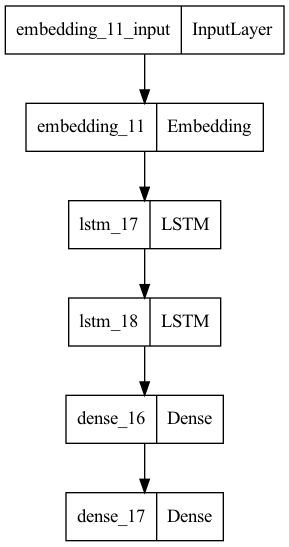

In [184]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_layer_names=True)

<h3> For Callbacks

In [185]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.1, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

<h3> Compile the Model

In [186]:
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=Adam(learning_rate=0.001))

In [187]:
history = model.fit(X, y, epochs=10, batch_size=200, validation_split=0.05, 
                    shuffle=True, callbacks=[checkpoint, reduce, tensorboard_Visualization]).history

Epoch 1/10


2023-04-01 19:14:34.813034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 19:14:34.815341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 19:14:34.817397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 10.5007 - accuracy: 0.0000e+00

2023-04-01 19:14:40.894168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 19:14:40.896750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 19:14:40.898748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: loss improved from inf to 10.50067, saving model to nextword1.h5
1/1 [==============================] - 8s 8s/step - loss: 10.5007 - accuracy: 0.0000e+00 - val_loss: 10.5006 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 10.4970 - accuracy: 1.0000
Epoch 2: loss improved from 10.50067 to 10.49698, saving model to nextword1.h5
1/1 [==============================] - 2s 2s/step - loss: 10.4970 - accuracy: 1.0000 - val_loss: 10.5005 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 10.4920 - accuracy: 1.0000
Epoch 3: loss improved from 10.49698 to 10.49204, saving model to nextword1.h5
1/1 [==============================] - 2s 2s/step - loss: 10.4920 - accuracy: 1.0000 - val_loss: 10.5004 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 10.4856 - accuracy: 0.8000
Epoch 4: loss improved from 10.49204 to 10.48560,

<h3>Save Down the Model

In [188]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))

<h3>Load Back in the Model

model = models.load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [ ]:
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
# tensorboard --logdir="./logsnextword1"
# http://DESKTOP-U3TSCVT:6006/

from IPython.display import Image 
pil_img = Image(filename='graph1.png')
display(pil_img)

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts()
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in main_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("Total input sequences: ", len(input_sequences))